### Now, lets see how to give the human feedback during RunTime:

* To pass the **Human Feedback** in the loop at the runtime, you have to change the entire structure of the graph.

* Here, you have to create a separate node for human feedback where in which you can use the interrupt_before on this. Now, you can edit the user input before passing to the ai assitant and you can get the new outputs according to the human.

The graph structure is as shown below:

In [1]:
from langchain_groq import ChatGroq
# from langchain_ollama import ChatOllama
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(model = "openai/gpt-oss-20b")
# llm = ChatOllama(model = "llama3.2")
response = llm.invoke("hi")
response

c:\Users\madda\Desktop\Udemy\udemy-langchain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='Hello! 👋 How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "hi". This is a greeting. The assistant should respond politely. The instruction says we can talk about anything. So a friendly greeting.'}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 72, 'total_tokens': 124, 'completion_time': 0.050962429, 'prompt_time': 0.003522136, 'queue_time': 0.043258724, 'total_time': 0.054484565}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--466739b0-50e1-4564-a08f-75d024cb2fae-0', usage_metadata={'input_tokens': 72, 'output_tokens': 52, 'total_tokens': 124})

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.checkpoint.memory import MemorySaver

# defining tools

def add(a:int, b:int) -> int:
    """Adds 2 integers and returns an integer
    args: 2 integer values
    output: addition of given 2 integer numbers
    """
    return a+b

def sub(a:int, b:int) -> int:
    """Subtracts 2 integers and returns an integer
    args: 2 integer values
    output: subtraction of given 2 integer numbers
    """
    return a-b

def multiply(a:int, b:int) -> int:
    """Multiplies 2 integers and returns an integer
    args: 2 integer values
    output: mulitplication of given 2 integer numbers
    """
    return a*b

def divide(a:int, b:int) -> float:
    """Divides 2 integers and returns a float value
    args: 2 integer values
    output: division of given 2 integer numbers
    """
    return a/b


In [3]:
tools = [add,sub,multiply,divide]

llm_with_tools = llm.bind_tools(tools)

In [4]:
def llm_call(state:MessagesState):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

def human_feedback(state:MessagesState):
    pass

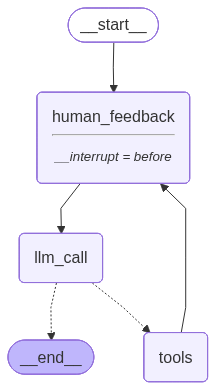

In [5]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display,Markdown,Image

builder = StateGraph(MessagesState)

builder.add_node("llm_call",llm_call)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback",human_feedback)

builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","llm_call")
builder.add_conditional_edges('llm_call',tools_condition)
builder.add_edge('tools','human_feedback')

memory = MemorySaver()
builder_graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
display(Image(builder_graph.get_graph().draw_mermaid_png()))

In [6]:
from pprint import pprint

In [7]:
config = {'configurable':{'thread_id':1}}

In [19]:
sys_msg = SystemMessage(content="You are a helpful assistant that helps to do simple math operations.")

for m in builder_graph.stream({'messages':"Add 2 and 3"},config,stream_mode="values"):
    m['messages'][-1].pretty_print()

================================ Human Message =================================

Add 2 and 3


In [36]:
user_input = input("Enter your value to update the state: ")
builder_graph.update_state(config,{'messages':user_input},as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a023a-a4bf-6afc-8028-ccb2ff3ad738'}}

In [37]:
for m in builder_graph.stream(None,config,stream_mode="values"):
    Markdown(m['messages'][-1].pretty_print())

================================ Human Message =================================

multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_9a31b239-7eb3-4a91-bf11-347e2db31c9b)
 Call ID: fc_9a31b239-7eb3-4a91-bf11-347e2db31c9b
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [38]:
for m in builder_graph.stream(None,config,stream_mode="values"):
    Markdown(m['messages'][-1].pretty_print())

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6
